In [1]:
# on-policy MC prediction, TD, n-step TD, TD(λ)

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import gym, gym_walk, gym_aima
import numpy as np
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
    prev_V = np.zeros(len(P))
    while True:
        V = np.zeros(len(P))
        for s in range(len(P)):
            for prob, next_state, reward, done in P[s][pi(s)]:
                V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
        if np.max(np.abs(prev_V - V)) < theta:
            break
        prev_V = V.copy()
    return V

In [5]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def print_state_value_function(V, P, n_cols=4, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{:.2f}'.format(v).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [7]:
def probability_success(env, pi, goal_state, iterations=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        while not done:
            state, _, done, _ = env.step(pi(state))
        results.append(state == goal_state)
    return np.sum(results)/len(results)

In [8]:
def mean_return(env, pi, iterations=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        results.append(0.0)
        while not done:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += reward
    return np.mean(results)

In [9]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [10]:
def plot_value_function(title, V_track, V_true=None, log=False):
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []
    for i, state in enumerate(V_track.T):
        if not (V_true is None) and V_true[i] < 0.1:
            continue
        line_type = next(linecycler)
        label = 'Estimated V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
        if not (V_true is None):
            label = 'True v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center left', bbox_to_anchor=(1.1+loc*0.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes')
    plt.show()

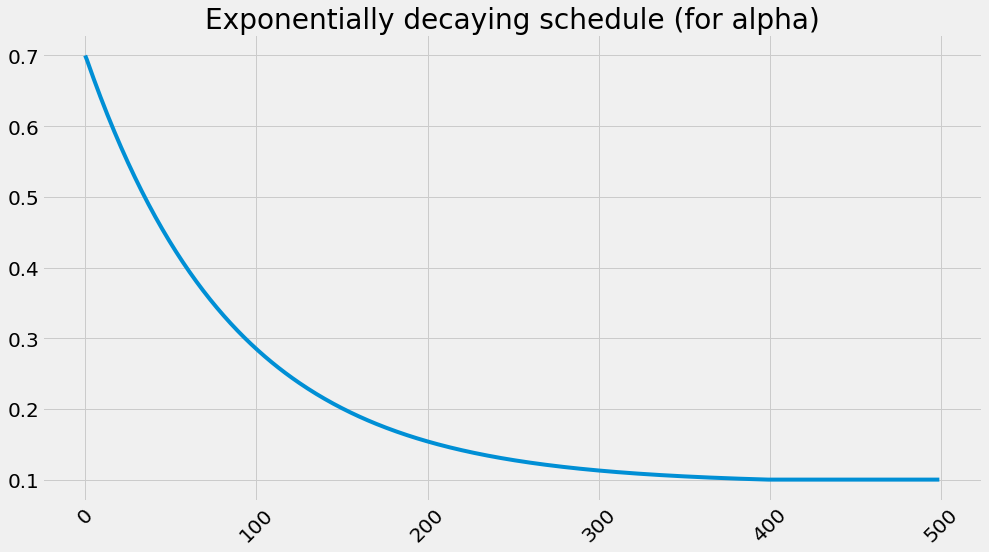

In [11]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, t):
    decay_steps = int(max_steps * decay_ratio) - 2
    rem_steps = max_steps - decay_steps - 2
    values = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    values = values * (init_value - min_value) + min_value   
    values = np.hstack((init_value, values, min_value)) 
    values = np.pad(values, (0, rem_steps), 'edge')
    return values[t]

plt.plot([decay_schedule(0.7, 0.1, 0.8, 500, i) for i in range(500)])
plt.title('Exponentially decaying schedule (for alpha)')
plt.xticks(rotation=45)
plt.show()

In [12]:
decay_schedule(1.0, 0, 0.8, 500, 499)

0.0

# Random walk/Deterministic walk with uniformly random policy

In [13]:
env = gym.make('RandomWalk-v0')
P = env.env.P

WEST, EAST = range(2)
pi = lambda s: {
    0:WEST, 1:WEST, 2:WEST, 3:WEST, 4:WEST, 5:WEST, 6:WEST
}[s]
V_true = policy_evaluation(pi, P)

print_state_value_function(V_true, P, n_cols=7)
print()
print_policy(pi, P, action_symbols=('<', '>'), n_cols=7)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=6)*100, 
    mean_return(env, pi)))

State-value function:
|           | 01   0.17 | 02   0.33 | 03   0.50 | 04   0.67 | 05   0.83 |           |

Policy:
|           | 01      < | 02      < | 03      < | 04      < | 05      < |           |
Reaches goal 50.30%. Obtains an average undiscounted return of 0.5030.


# Monte-Carlo prediction

In [14]:
def generate_episode(pi, env, max_steps=20):
    done, episode = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = pi(state) 
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward, next_state, done))
            if done:
                break
            if t >= max_steps - 1:
                episode = []
                break
            state = next_state
    return np.array(episode, np.object)

In [15]:
def mc_prediction(pi, 
                  env, 
                  gamma=1.0,
                  init_alpha=0.5,
                  min_alpha=0.01,
                  alpha_decay_ratio=0.3,
                  n_episodes=500, 
                  max_steps=100):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS = env.observation_space.n
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))

    for t in tqdm(range(n_episodes)):
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        episode = generate_episode(pi, env, max_steps)
        return_visited = np.zeros(nS, dtype=np.bool)
        for step_idx, (state, _, reward, _, _) in enumerate(episode):
            if return_visited[state]:
                continue
            return_visited[state] = True

            seq_len = len(episode[step_idx:])
            G = np.sum(discounts[:seq_len] * episode[step_idx:, 2])
            V[state] = V[state] + alpha * (G - V[state])
        V_track[t] = V
    return V.copy(), V_track

In [16]:
V_mc, V_track_mc = mc_prediction(pi, env)
print_state_value_function(V_mc, P, n_cols=7)
print()
print_state_value_function(V_mc - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_mc, V_true))


State-value function:
|           | 01   0.17 | 02   0.33 | 03   0.45 | 04   0.64 | 05   0.87 |           |

State-value function errors:
|           | 01  -0.00 | 02  -0.00 | 03  -0.05 | 04  -0.03 | 05   0.03 |           |
RMSE: 0.025


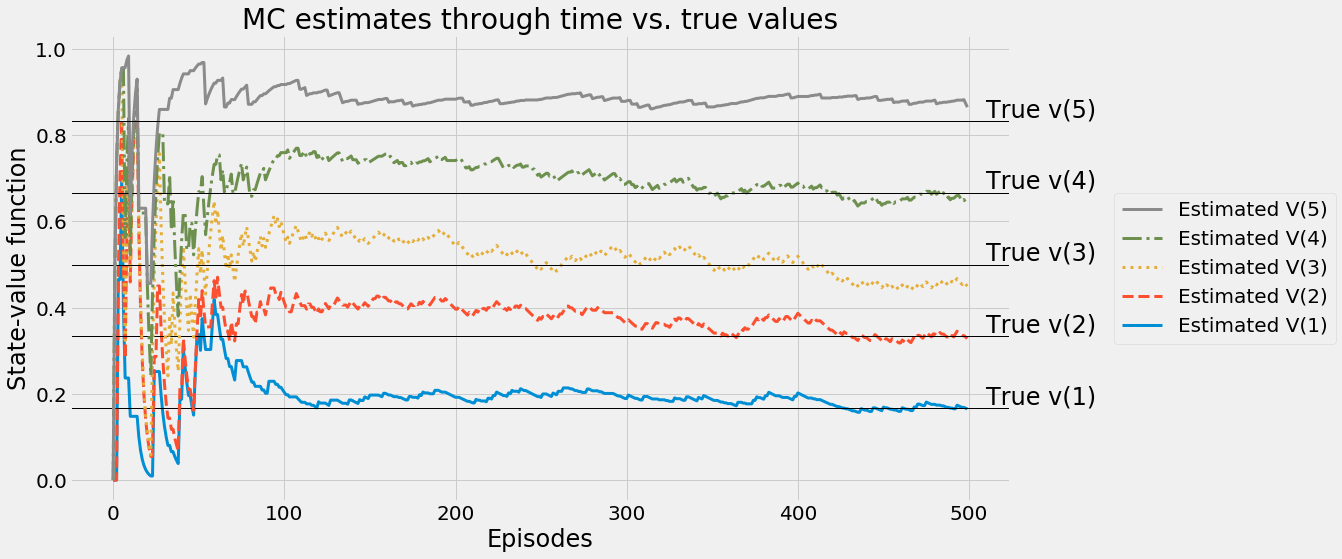

In [17]:
plot_value_function('MC estimates through time vs. true values', V_track_mc, V_true, log=False)

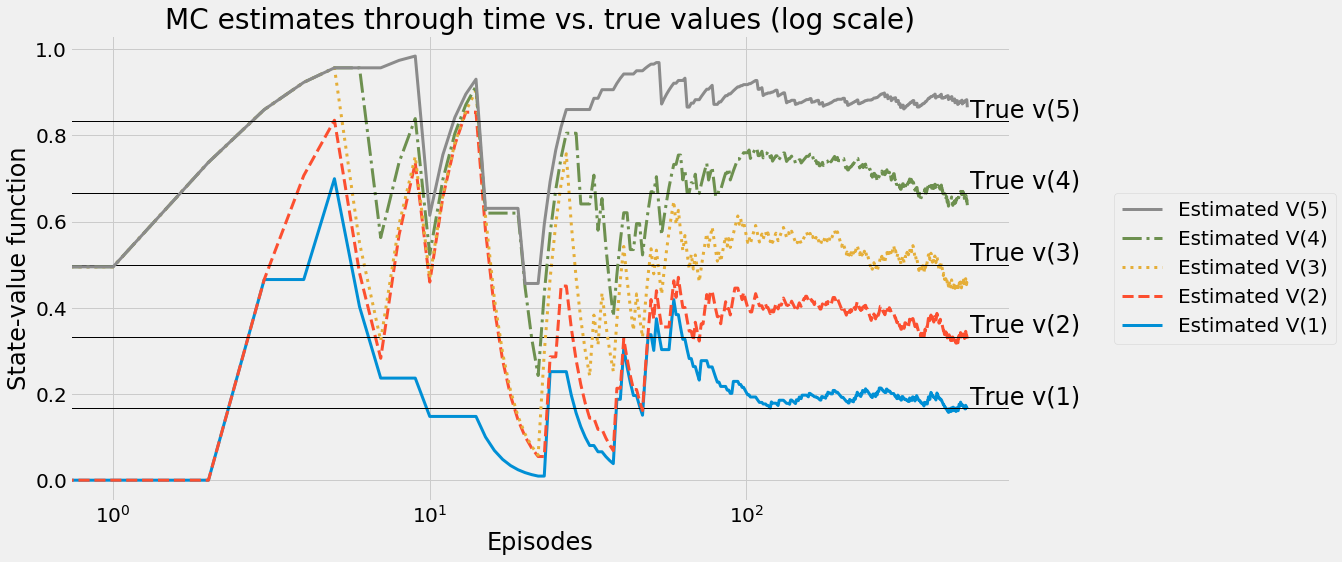

In [18]:
plot_value_function('MC estimates through time vs. true values (log scale)', V_track_mc, V_true, log=True)

# Temporal-Difference Prediction (TD)

In [19]:
def td(pi, 
       env, 
       gamma=1.0,
       init_alpha=0.5,
       min_alpha=0.01,
       alpha_decay_ratio=0.3,
       n_episodes=500):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS = env.observation_space.n
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    
    for t in tqdm(range(n_episodes)):
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_estimate = reward + gamma * V[next_state] * (not done)
            td_error = td_estimate - V[state]
            V[state] = V[state] + alpha * td_error
            state = next_state
        V_track[t] = V
    return V, V_track

In [20]:
V_td, V_track_td = td(pi, env)
print_state_value_function(V_td, P, n_cols=7)
print()
print_state_value_function(V_td - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))


State-value function:
|           | 01   0.17 | 02   0.33 | 03   0.48 | 04   0.65 | 05   0.84 |           |

State-value function errors:
|           | 01   0.00 | 02  -0.00 | 03  -0.02 | 04  -0.02 | 05   0.01 |           |
RMSE: 0.0109


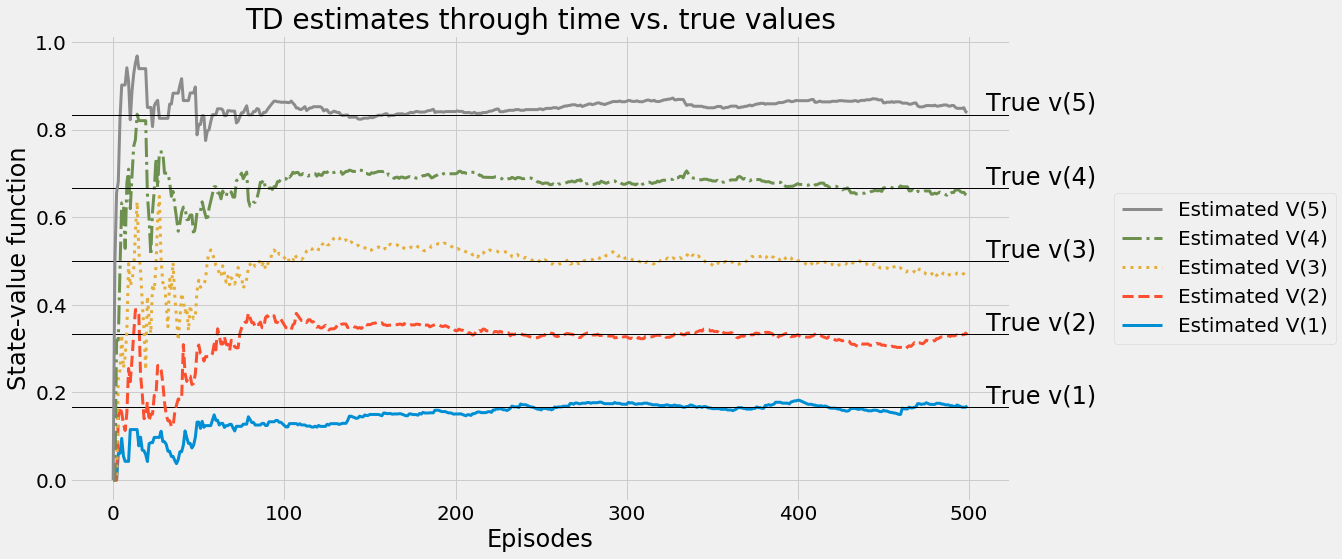

In [21]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

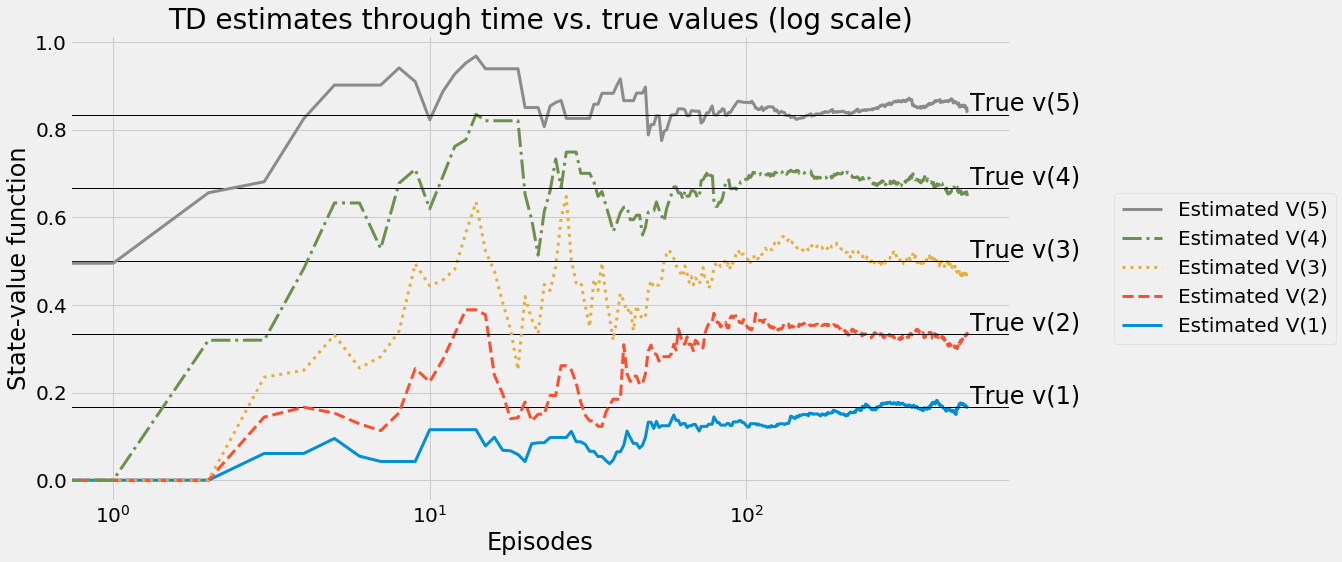

In [22]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

# Comparing MC and TD

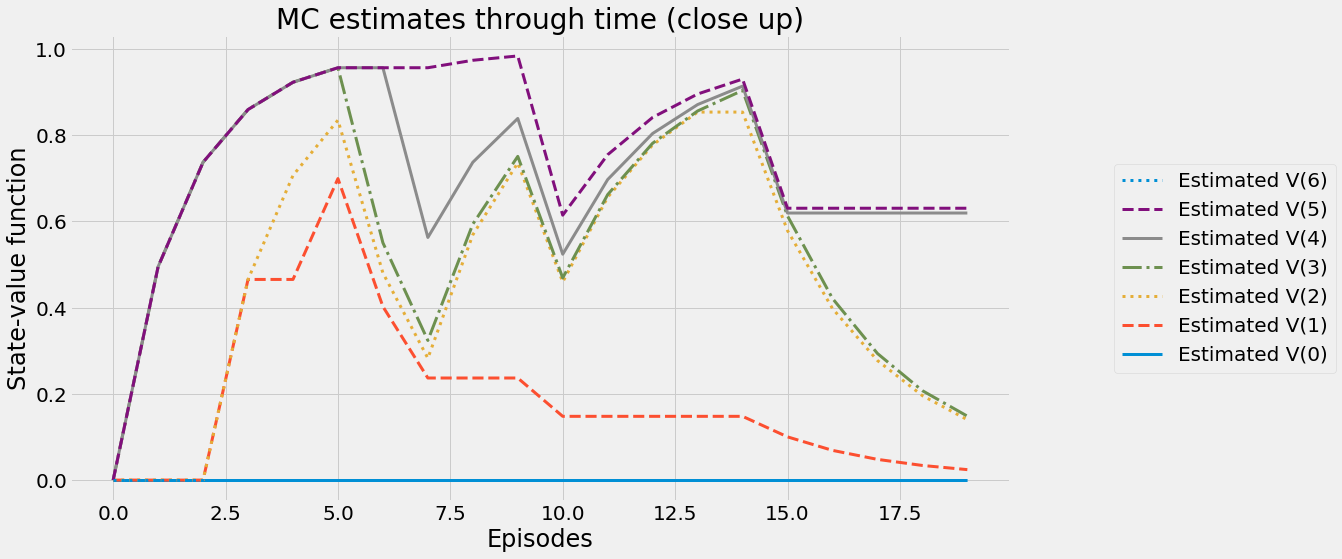

In [23]:
plot_value_function('MC estimates through time (close up)', V_track_mc[:20], None, log=False)

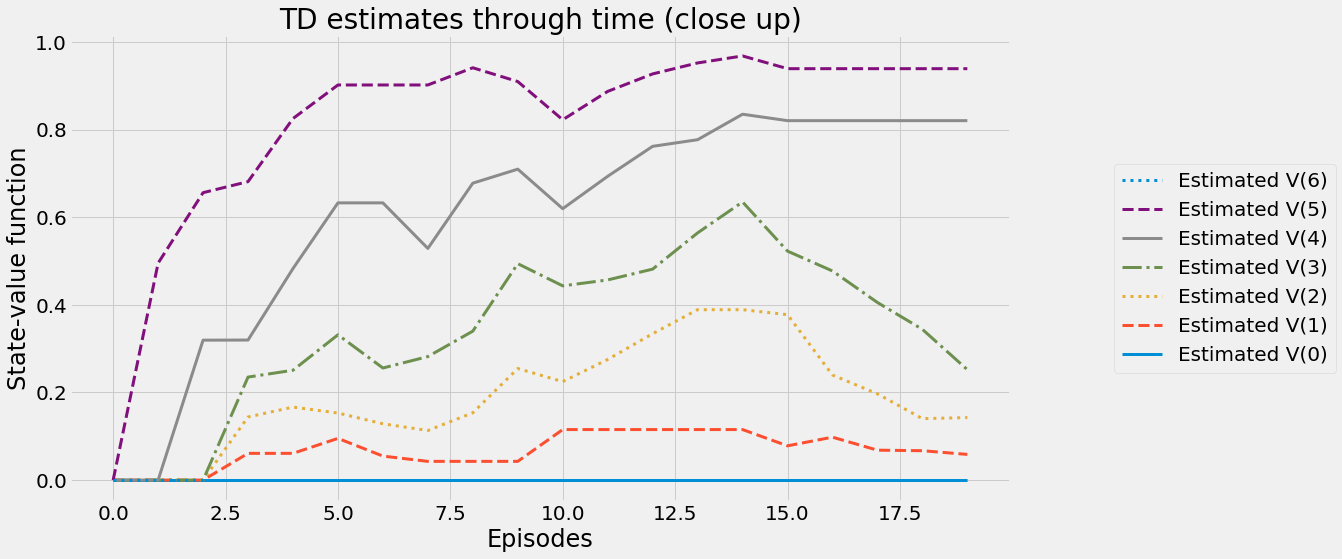

In [24]:
plot_value_function('TD estimates through time (close up)', V_track_td[:20], None, log=False)

# n-step TD

In [25]:
def ntd(pi, 
        env, 
        gamma=1.0,
        init_alpha=0.5,
        min_alpha=0.01,
        alpha_decay_ratio=0.3,
        n_step=3,
        n_episodes=500):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS = env.observation_space.n
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    gammas = np.logspace(0, n_step+1, num=n_step+1, base=gamma, endpoint=False)

    for t in tqdm(range(n_episodes)):
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        state, done, hist = env.reset(), False, None
        while not done or len(hist) > 0:
            if not done:
                action = pi(state)
                next_state, reward, done, _ = env.step(action)
                experience = np.array([state, reward, next_state, done], dtype=object)
                hist = experience[np.newaxis] if hist is None else np.vstack((experience, hist))[:n_step]
            if len(hist) == n_step or done:
                h = np.flip(hist, axis=0)
                ns = h[-1, 2]
                s, r, Vns, d =  h[0, 0], h[:len(h), 1], V[ns], h[-1, 3]
                G = np.sum(np.append(r * gammas[:len(h)], Vns * gammas[len(h)-1] * (not d)))
                V[s] = V[s] + alpha * (G - V[s])
                hist = hist[:-1]
            state = next_state    

        V_track[t] = V
    return V, V_track

In [26]:
V_ntd, V_track_ntd = ntd(pi, env)
print_state_value_function(V_ntd, P, n_cols=7)
print()
print_state_value_function(V_ntd - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))


State-value function:
|           | 01   0.17 | 02   0.33 | 03   0.46 | 04   0.63 | 05   0.83 |           |

State-value function errors:
|           | 01   0.01 | 02   0.00 | 03  -0.04 | 04  -0.03 | 05   0.00 |           |
RMSE: 0.0198


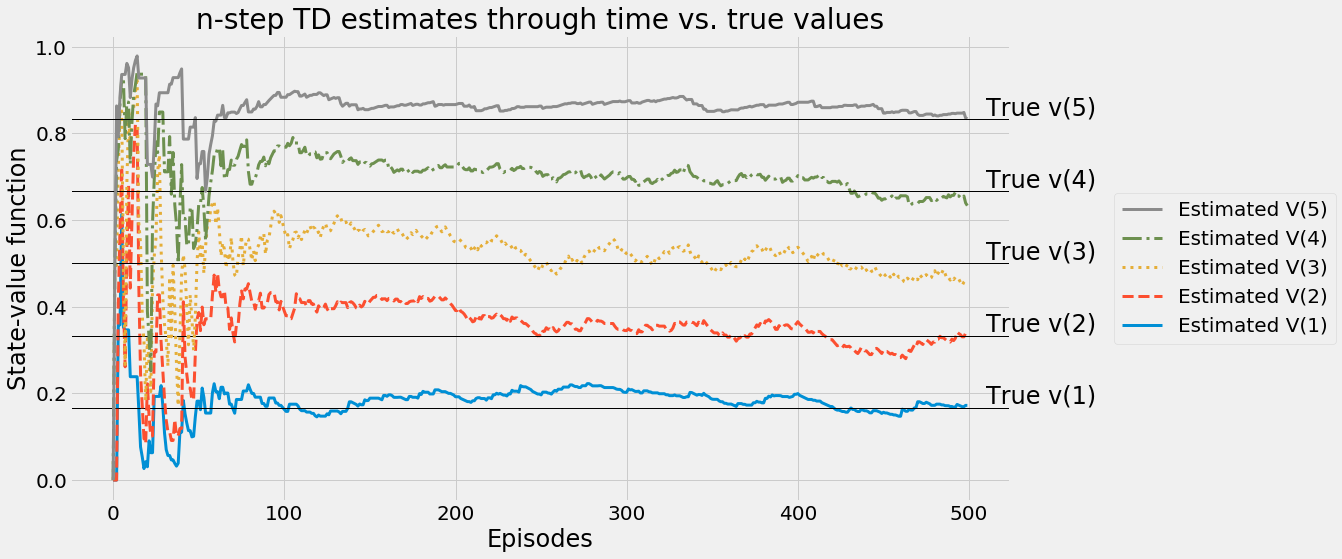

In [27]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

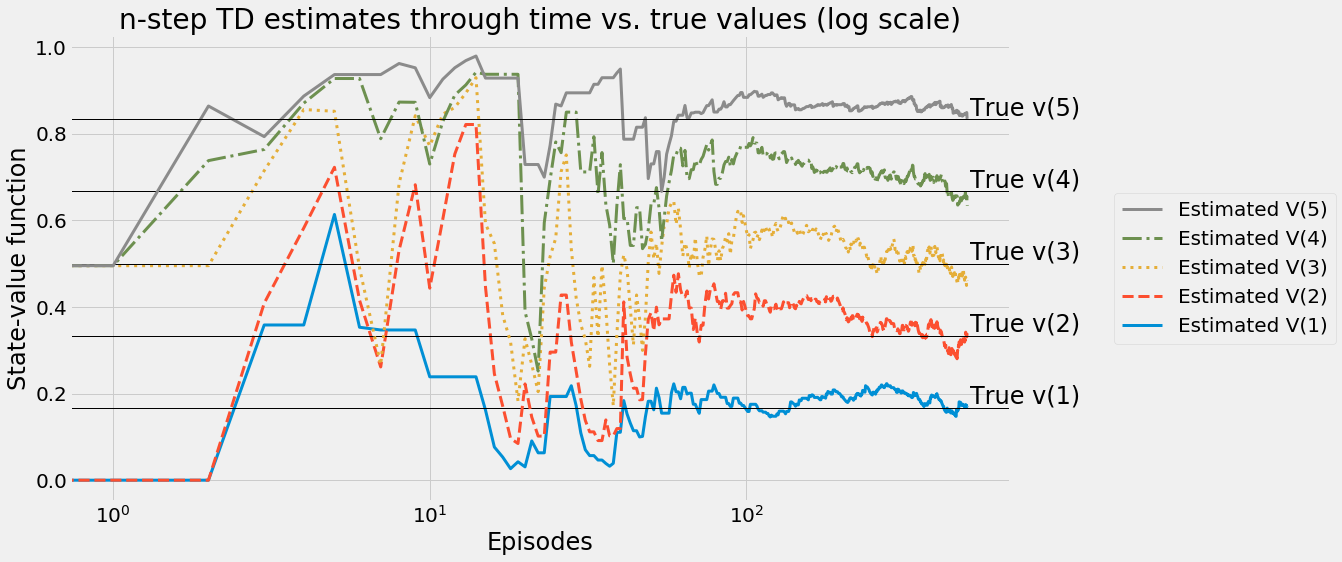

In [28]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

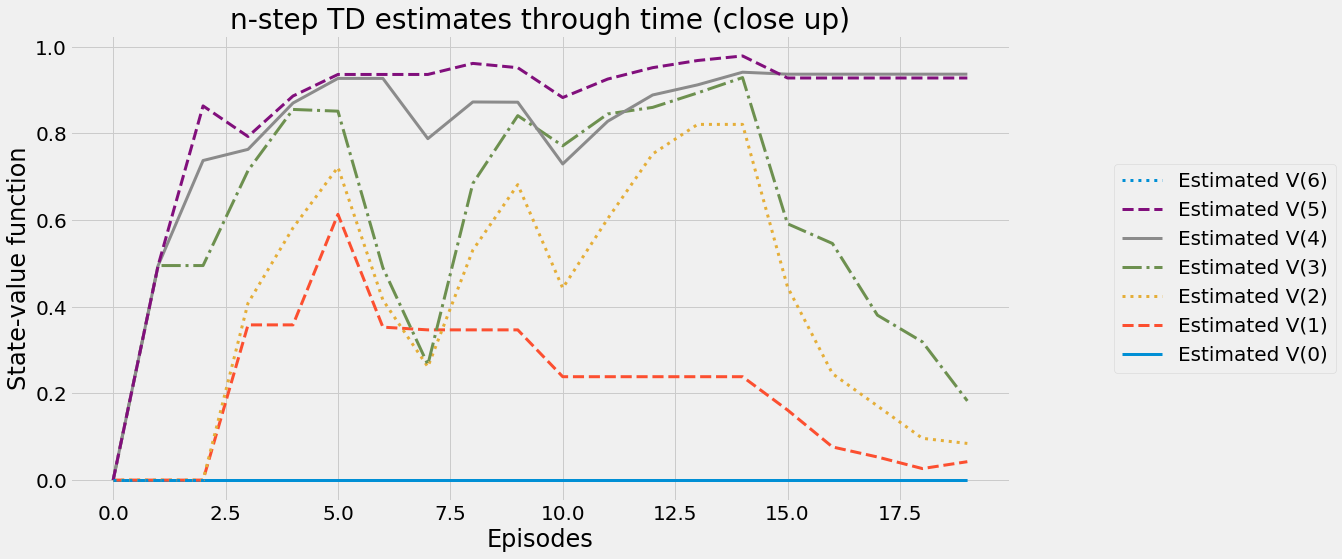

In [29]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:20], None, log=False)

# TD(λ)

In [30]:
def td_lambda(pi, 
              env, 
              gamma=1.0,
              init_alpha=0.5,
              min_alpha=0.01,
              alpha_decay_ratio=0.3,
              lambda_=0.3,
              n_episodes=500):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS = env.observation_space.n
    V = np.zeros(nS)
    E = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    
    for t in tqdm(range(n_episodes)):
        E.fill(0)
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_estimate = reward + gamma * V[next_state] * (not done)
            td_error = td_estimate - V[state]
            E[state] = E[state] + 1
            V = V + alpha * td_error * E
            E = gamma * lambda_ * E
            state = next_state
        V_track[t] = V
    return V, V_track

In [31]:
V_tdl, V_track_tdl = td_lambda(pi, env)
print_state_value_function(V_tdl, P, n_cols=7)
print()
print_state_value_function(V_tdl - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))


State-value function:
|           | 01   0.18 | 02   0.34 | 03   0.48 | 04   0.65 | 05   0.84 |           |

State-value function errors:
|           | 01   0.01 | 02   0.00 | 03  -0.02 | 04  -0.02 | 05   0.01 |           |
RMSE: 0.011


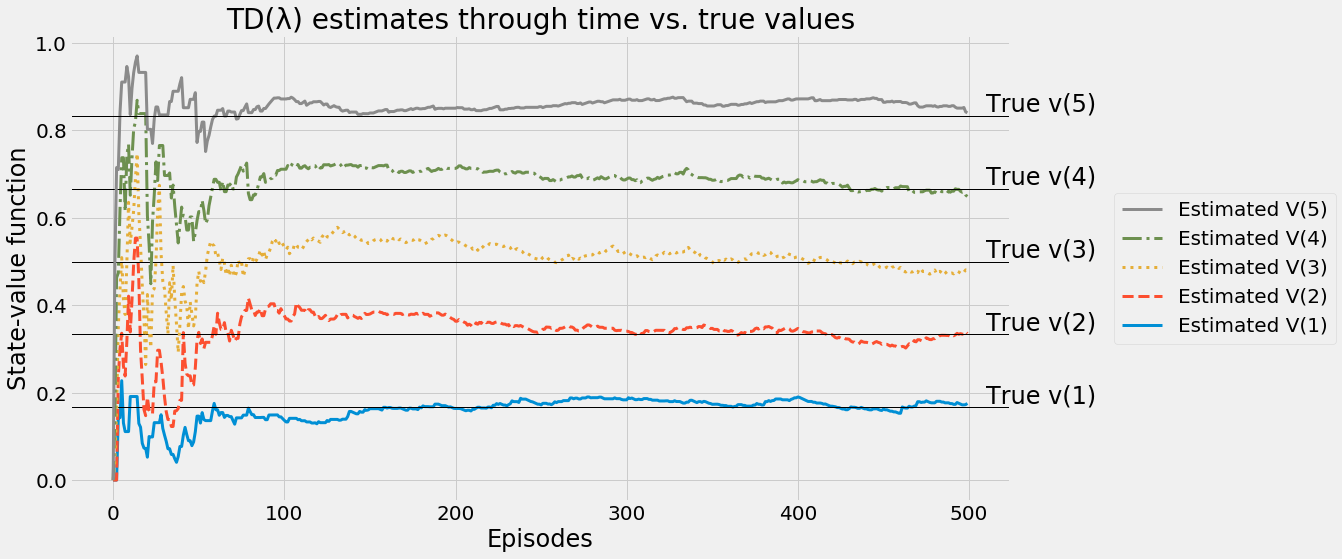

In [32]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

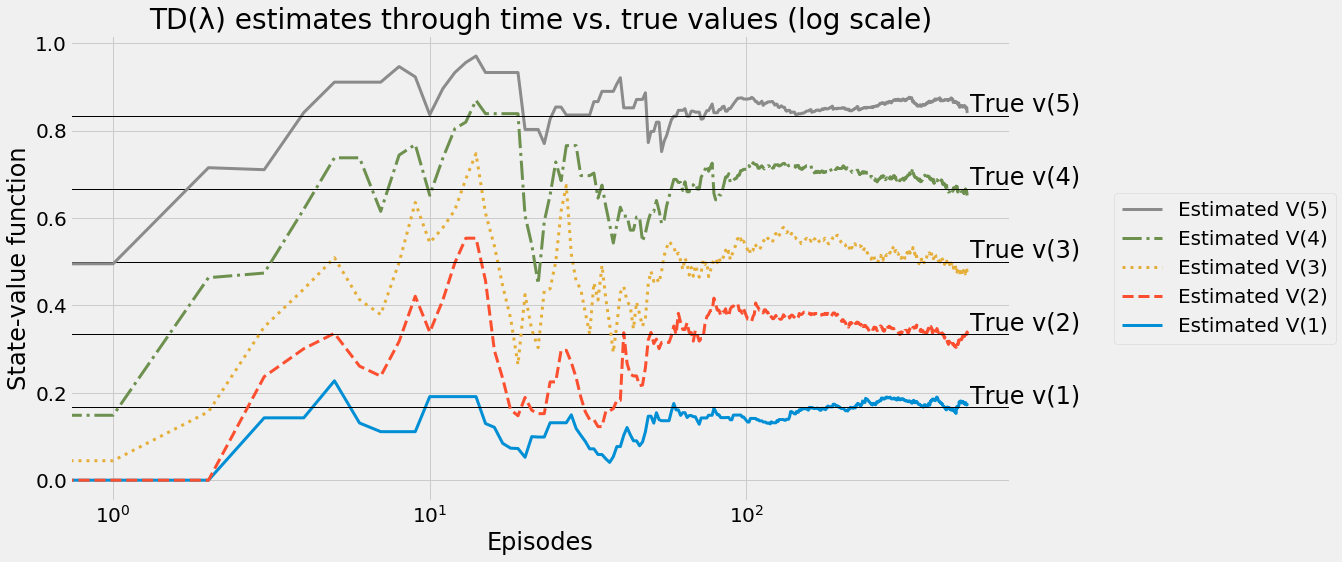

In [33]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

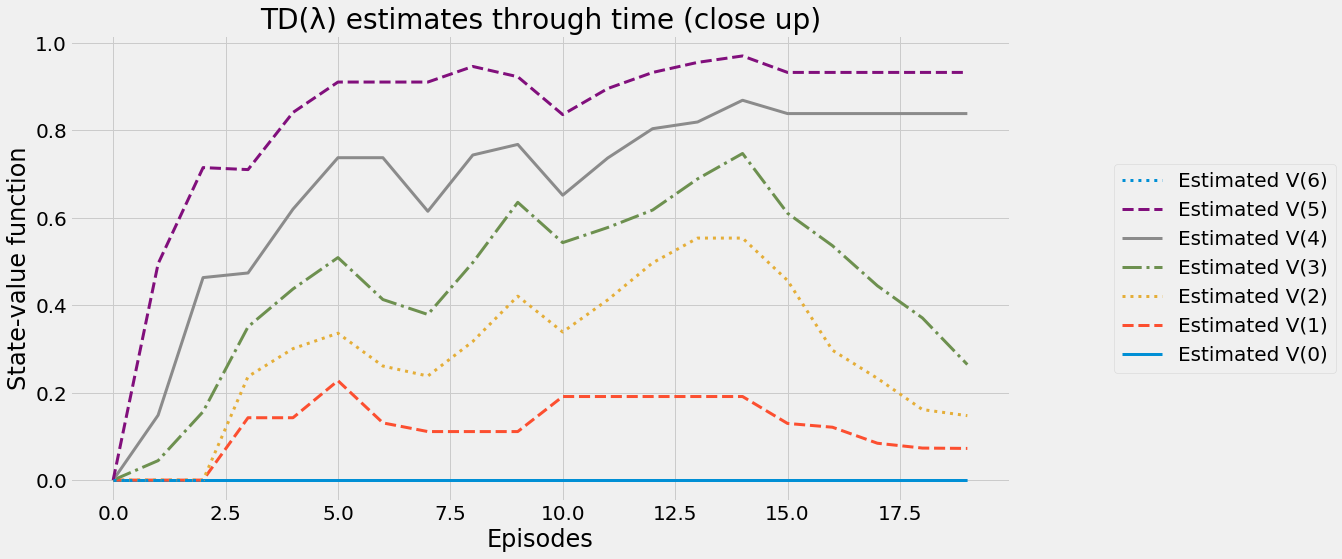

In [34]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:20], None, log=False)

# Russell & Norvig Gridworld environment and sample policy

In [35]:
env = gym.make('RussellNorvigGridworld-v0')
P = env.env.P

WEST, SOUTH, EAST, NORTH = range(4)
pi = lambda s: {
    0:EAST, 1:EAST, 2:EAST, 3:WEST,
    4:EAST, 5:WEST, 6:NORTH, 7:WEST,
    8:EAST, 9:NORTH, 10:NORTH, 11:WEST
}[s]
print_policy(pi, P)
print('Reaches goal {:.2f}%\n'.format(probability_success(env, pi, goal_state=3)*100))

V_true = policy_evaluation(pi, P, gamma=1.0)
print_state_value_function(V_true, P)

Policy:
| 00      > | 01      > | 02      > |           |
| 04      > |           | 06      ^ |           |
| 08      > | 09      ^ | 10      ^ | 11      < |
Reaches goal 89.20%

State-value function:
| 00   0.75 | 01   0.87 | 02   0.92 |           |
| 04   0.21 |           | 06   0.66 |           |
| 08   0.07 | 09   0.10 | 10   0.53 | 11   0.32 |


# Russell & Norvig Gridworld policy estimation (policy to state-value function)

In [36]:
V_mc, V_track_mc = mc_prediction(pi, env)
print_state_value_function(V_mc, P)
print()
print_state_value_function(V_mc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_mc, V_true))


State-value function:
| 00   0.76 | 01   0.86 | 02   0.94 |           |
| 04   0.36 |           | 06   0.70 |           |
| 08   0.12 | 09   0.15 | 10   0.59 | 11   0.25 |

State-value function errors:
| 00   0.01 | 01  -0.00 | 02   0.02 |           |
| 04   0.15 |           | 06   0.04 |           |
| 08   0.06 | 09   0.06 | 10   0.06 | 11  -0.07 |
RMSE: 0.0562


In [37]:
V_td, V_track_td = td(pi, env)
print_state_value_function(V_td, P)
print()
print_state_value_function(V_td - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))


State-value function:
| 00   0.55 | 01   0.83 | 02   0.94 |           |
| 04   0.11 |           | 06   0.69 |           |
| 08   0.10 | 09   0.12 | 10   0.58 | 11   0.13 |

State-value function errors:
| 00  -0.20 | 01  -0.04 | 02   0.02 |           |
| 04  -0.09 |           | 06   0.03 |           |
| 08   0.03 | 09   0.02 | 10   0.05 | 11  -0.18 |
RMSE: 0.0859


In [38]:
V_ntd, V_track_ntd = ntd(pi, env)
print_state_value_function(V_ntd, P)
print()
print_state_value_function(V_ntd - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))


State-value function:
| 00   0.71 | 01   0.87 | 02   0.93 |           |
| 04   0.33 |           | 06   0.71 |           |
| 08   0.10 | 09   0.12 | 10   0.59 | 11   0.32 |

State-value function errors:
| 00  -0.04 | 01   0.00 | 02   0.02 |           |
| 04   0.13 |           | 06   0.05 |           |
| 08   0.03 | 09   0.02 | 10   0.06 | 11   0.00 |
RMSE: 0.0455


In [39]:
V_tdl, V_track_tdl = td_lambda(pi, env)
print_state_value_function(V_tdl, P)
print()
print_state_value_function(V_tdl - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))


State-value function:
| 00   0.63 | 01   0.84 | 02   0.94 |           |
| 04   0.24 |           | 06   0.70 |           |
| 08   0.12 | 09   0.13 | 10   0.59 | 11   0.21 |

State-value function errors:
| 00  -0.12 | 01  -0.03 | 02   0.02 |           |
| 04   0.03 |           | 06   0.04 |           |
| 08   0.05 | 09   0.04 | 10   0.06 | 11  -0.11 |
RMSE: 0.0563


# FrozenLake environment and sample policy

In [40]:
env = gym.make('FrozenLake-v0')
P = env.env.P

WEST, SOUTH, EAST, NORTH = range(4)
pi = lambda s: {
    0:EAST, 1:NORTH, 2:SOUTH, 3:NORTH,
    4:WEST, 5:WEST, 6:SOUTH, 7:WEST,
    8:NORTH, 9:SOUTH, 10:SOUTH, 11:WEST,
    12:WEST, 13:EAST, 14:SOUTH, 15:WEST
}[s]
print_policy(pi, P)
print('Reaches goal {:.2f}%\n'.format(probability_success(env, pi, goal_state=15)*100))

V_true = policy_evaluation(pi, P, gamma=0.99)
print_state_value_function(V_true, P)

Policy:
| 00      > | 01      ^ | 02      v | 03      ^ |
| 04      < |           | 06      v |           |
| 08      ^ | 09      v | 10      v |           |
|           | 13      > | 14      v |           |
Reaches goal 36.60%

State-value function:
| 00   0.27 | 01   0.22 | 02   0.18 | 03   0.17 |
| 04   0.33 |           | 06   0.14 |           |
| 08   0.40 | 09   0.49 | 10   0.43 |           |
|           | 13   0.64 | 14   0.81 |           |


# FrozenLake policy estimation (policy to state-value function)

In [41]:
V_mc, V_track_mc = mc_prediction(pi, env, gamma=0.99)
print_state_value_function(V_mc, P)
print()
print_state_value_function(V_mc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_mc, V_true))


State-value function:
| 00   0.28 | 01   0.23 | 02   0.18 | 03   0.20 |
| 04   0.33 |           | 06   0.16 |           |
| 08   0.38 | 09   0.46 | 10   0.43 |           |
|           | 13   0.59 | 14   0.75 |           |

State-value function errors:
| 00   0.00 | 01   0.01 | 02   0.00 | 03   0.03 |
| 04  -0.00 |           | 06   0.01 |           |
| 08  -0.03 | 09  -0.02 | 10   0.00 |           |
|           | 13  -0.05 | 14  -0.06 |           |
RMSE: 0.0245


In [42]:
V_td, V_track_td = td(pi, env, gamma=0.99)
print_state_value_function(V_td, P)
print()
print_state_value_function(V_td - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))


State-value function:
| 00   0.24 | 01   0.19 | 02   0.15 | 03   0.14 |
| 04   0.30 |           | 06   0.15 |           |
| 08   0.37 | 09   0.45 | 10   0.40 |           |
|           | 13   0.61 | 14   0.76 |           |

State-value function errors:
| 00  -0.04 | 01  -0.03 | 02  -0.02 | 03  -0.03 |
| 04  -0.03 |           | 06   0.01 |           |
| 08  -0.03 | 09  -0.03 | 10  -0.03 |           |
|           | 13  -0.03 | 14  -0.05 |           |
RMSE: 0.0265


In [43]:
V_ntd, V_track_ntd = ntd(pi, env, gamma=0.99)
print_state_value_function(V_ntd, P)
print()
print_state_value_function(V_ntd - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))


State-value function:
| 00   0.30 | 01   0.24 | 02   0.20 | 03   0.20 |
| 04   0.38 |           | 06   0.16 |           |
| 08   0.43 | 09   0.49 | 10   0.43 |           |
|           | 13   0.63 | 14   0.78 |           |

State-value function errors:
| 00   0.03 | 01   0.02 | 02   0.03 | 03   0.03 |
| 04   0.04 |           | 06   0.02 |           |
| 08   0.03 | 09   0.00 | 10  -0.00 |           |
|           | 13  -0.01 | 14  -0.03 |           |
RMSE: 0.0211


In [44]:
V_tdl, V_track_tdl = td_lambda(pi, env, gamma=0.99)
print_state_value_function(V_tdl, P)
print()
print_state_value_function(V_tdl - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))


State-value function:
| 00   0.26 | 01   0.21 | 02   0.17 | 03   0.16 |
| 04   0.33 |           | 06   0.16 |           |
| 08   0.40 | 09   0.48 | 10   0.42 |           |
|           | 13   0.63 | 14   0.77 |           |

State-value function errors:
| 00  -0.01 | 01  -0.01 | 02  -0.00 | 03  -0.01 |
| 04   0.00 |           | 06   0.01 |           |
| 08  -0.00 | 09  -0.01 | 10  -0.01 |           |
|           | 13  -0.01 | 14  -0.04 |           |
RMSE: 0.0124


# FrozenLake state-value function estimation

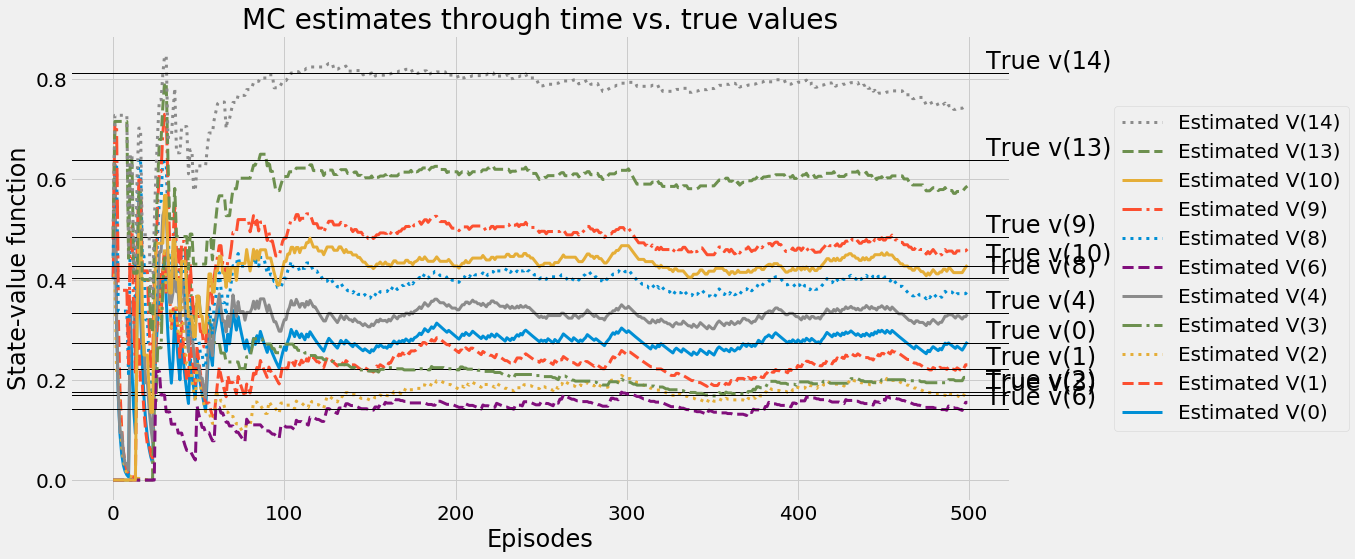

In [45]:
plot_value_function('MC estimates through time vs. true values', V_track_mc, V_true, log=False)

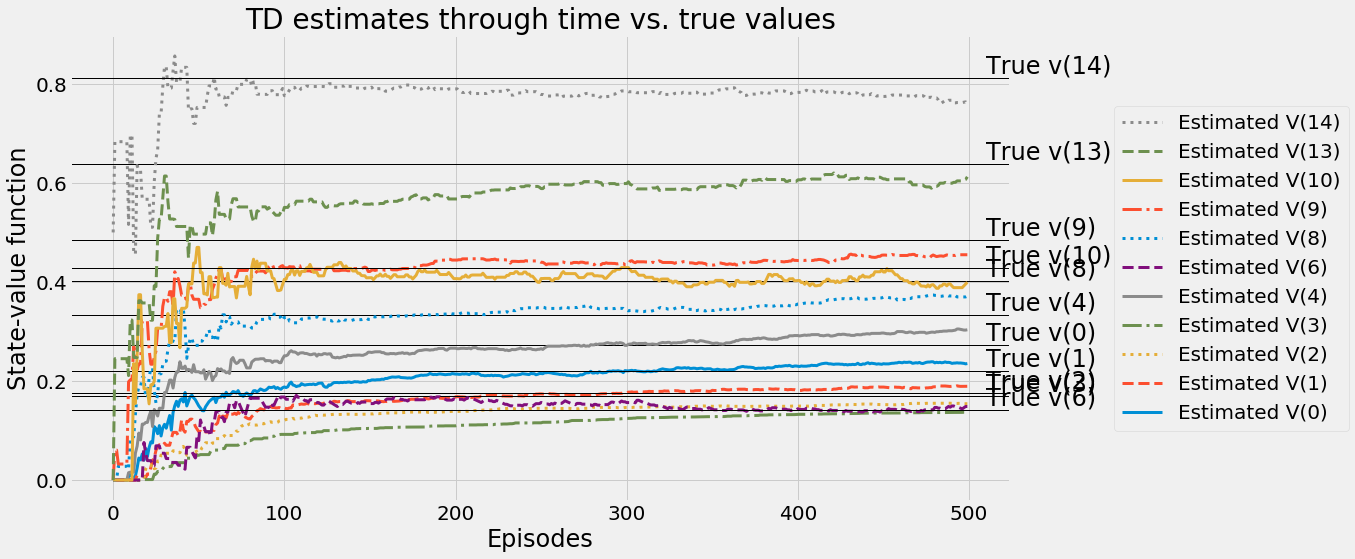

In [46]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

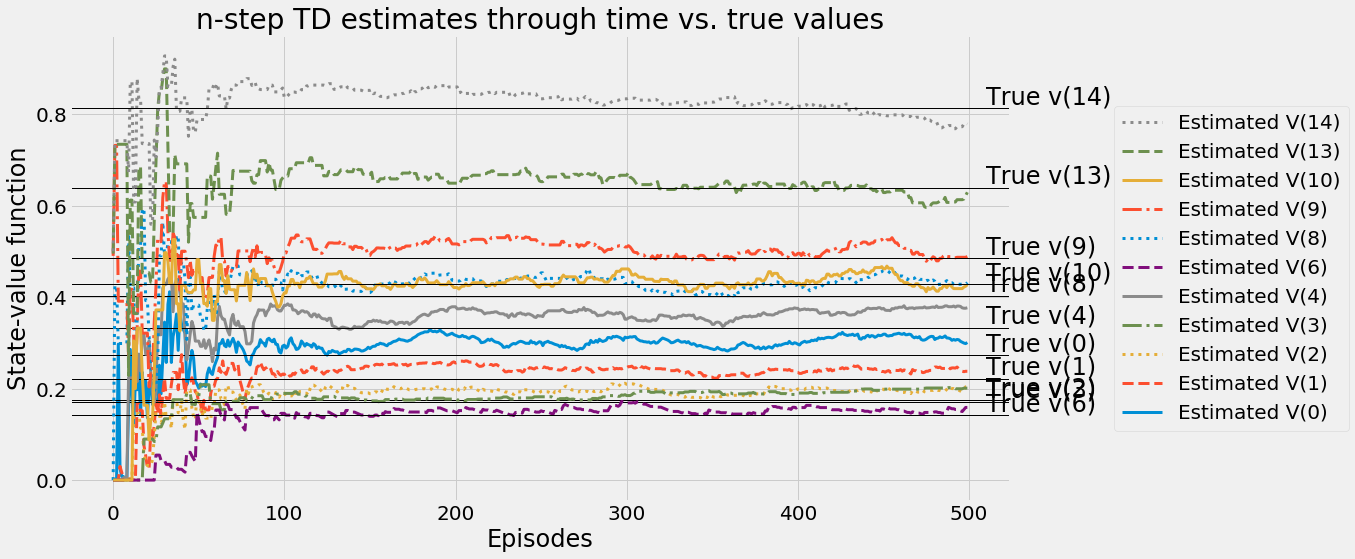

In [47]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

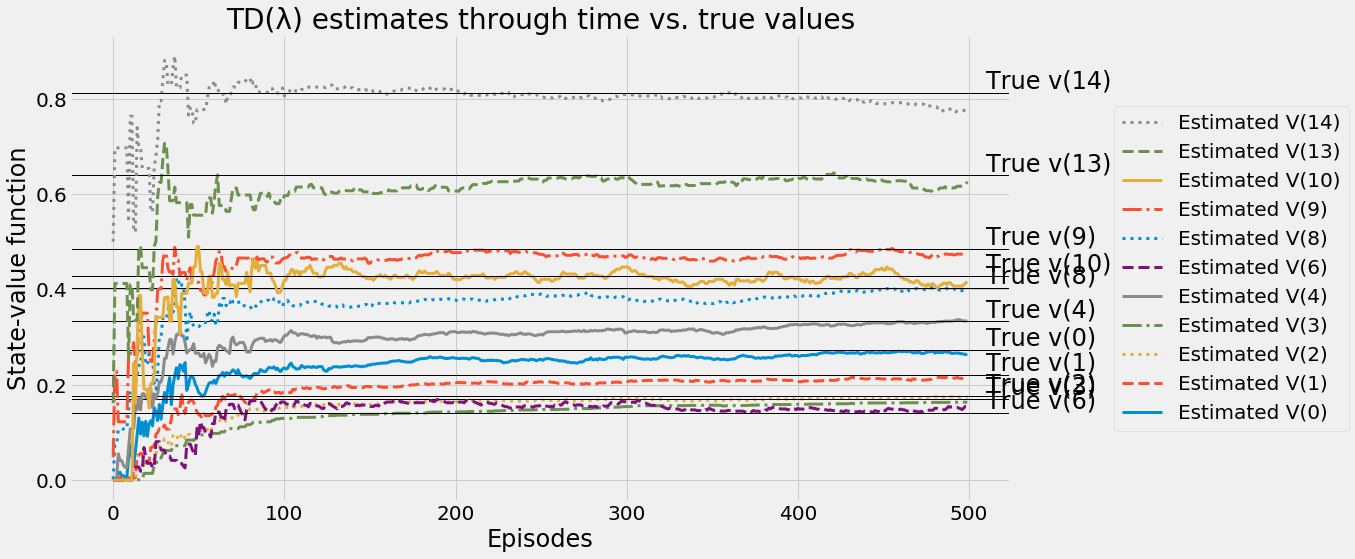

In [48]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

# FrozenLake state-value function estimation (x axis in log scale)

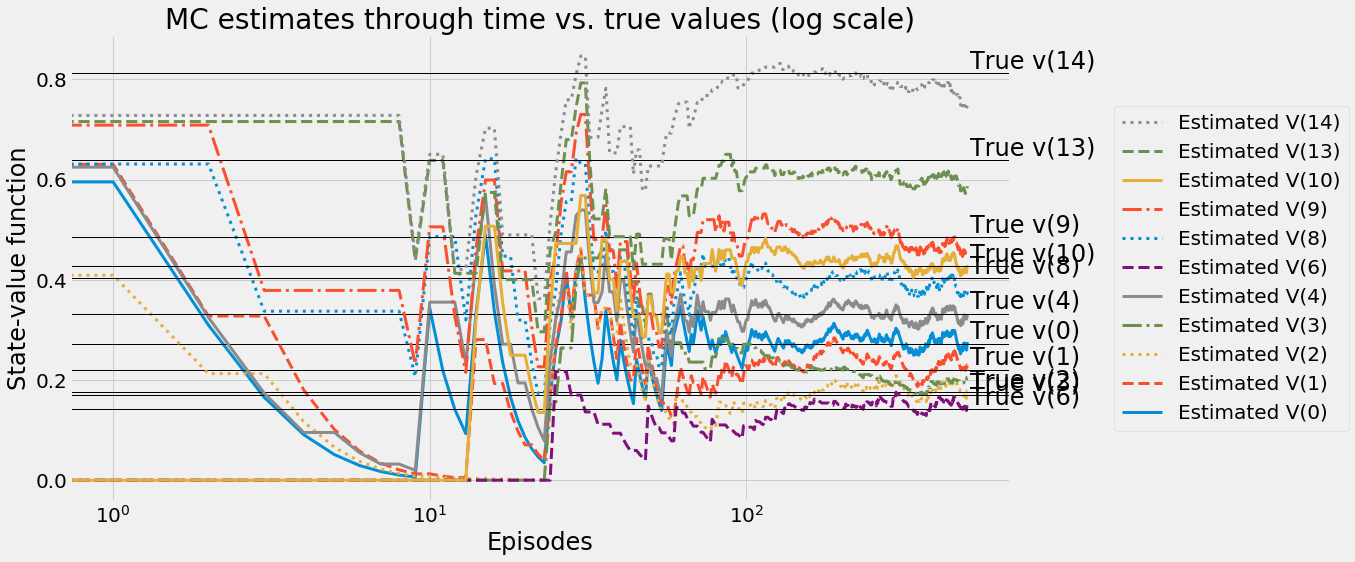

In [49]:
plot_value_function('MC estimates through time vs. true values (log scale)', V_track_mc, V_true, log=True)

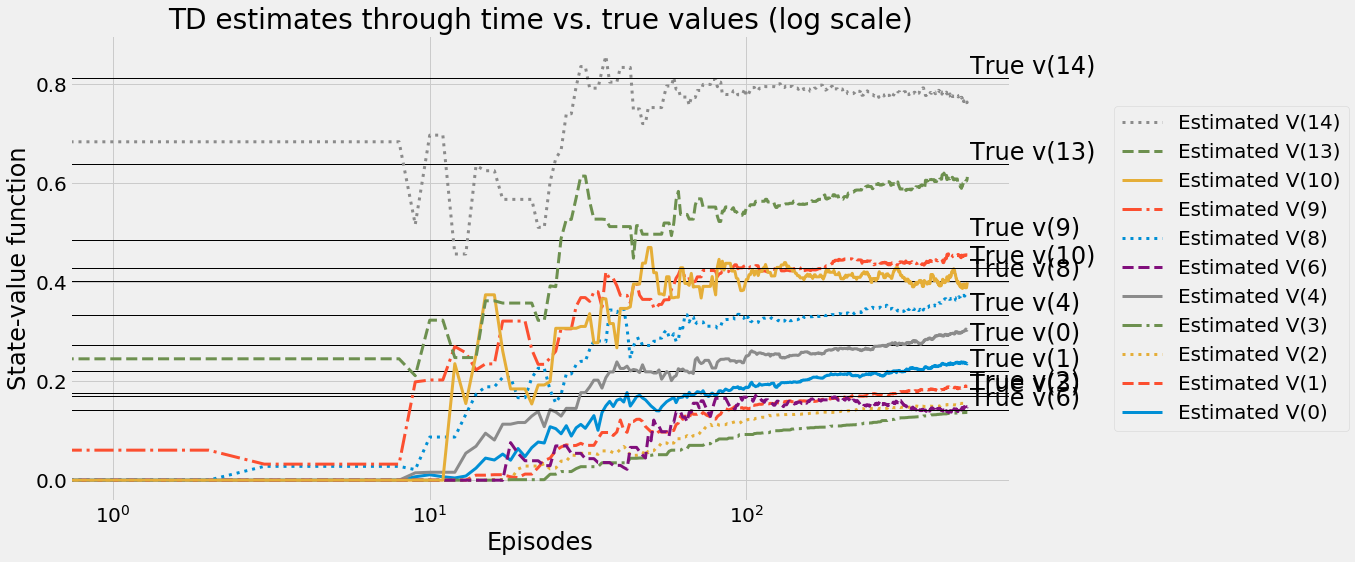

In [50]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

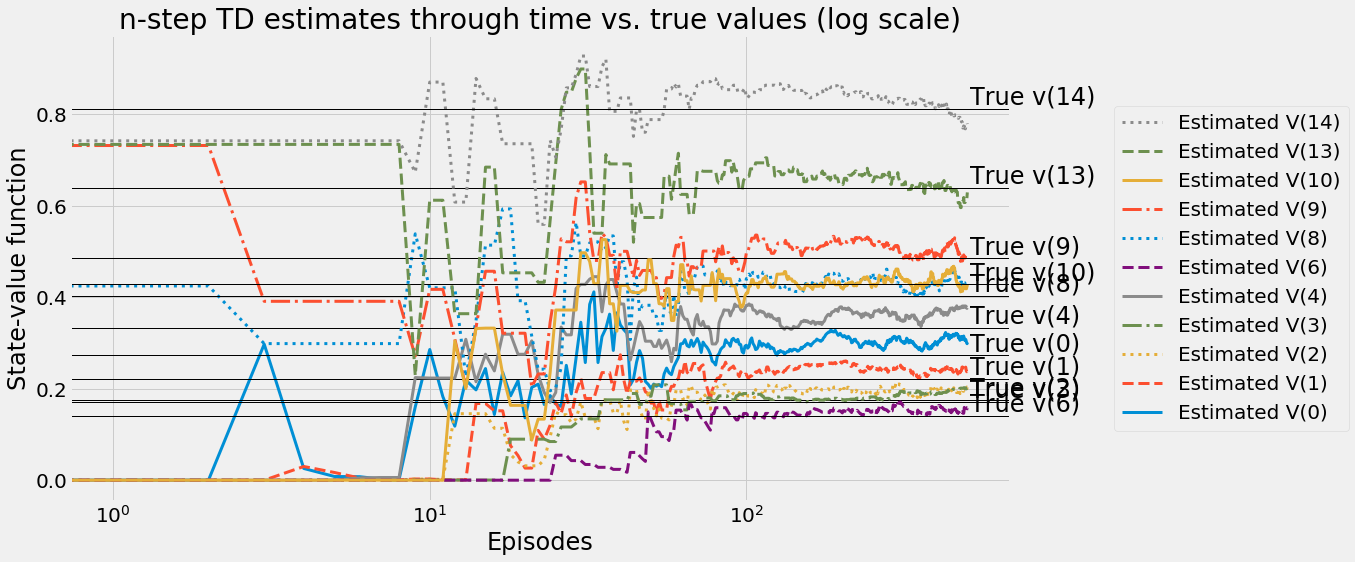

In [51]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

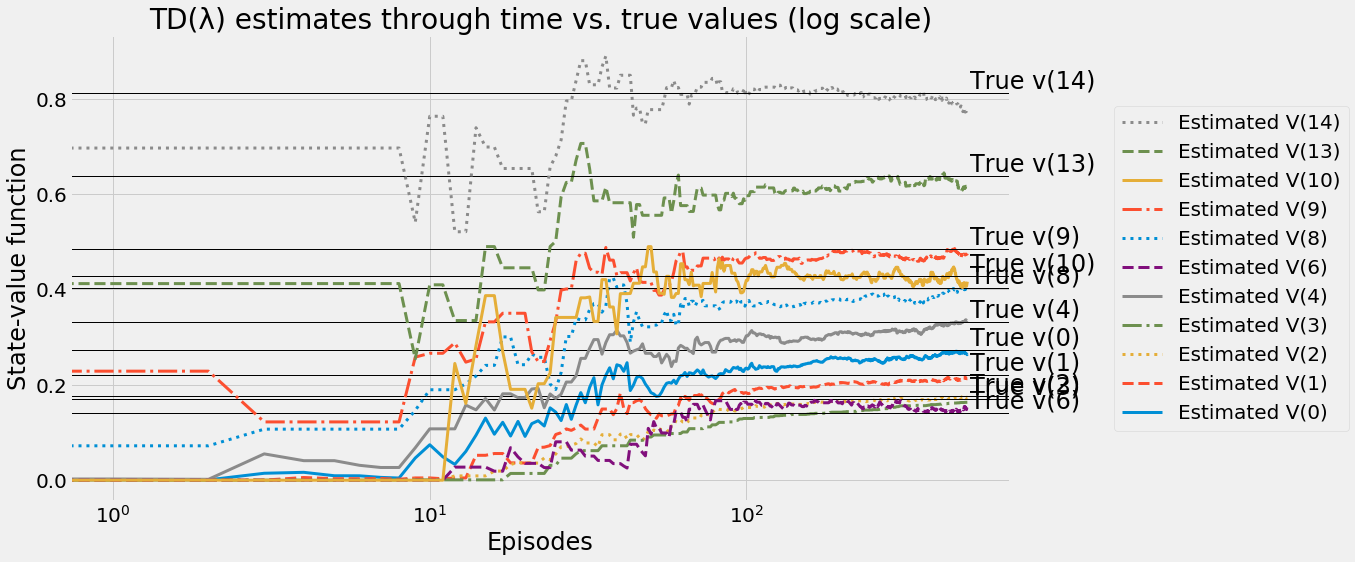

In [52]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

# Close ups

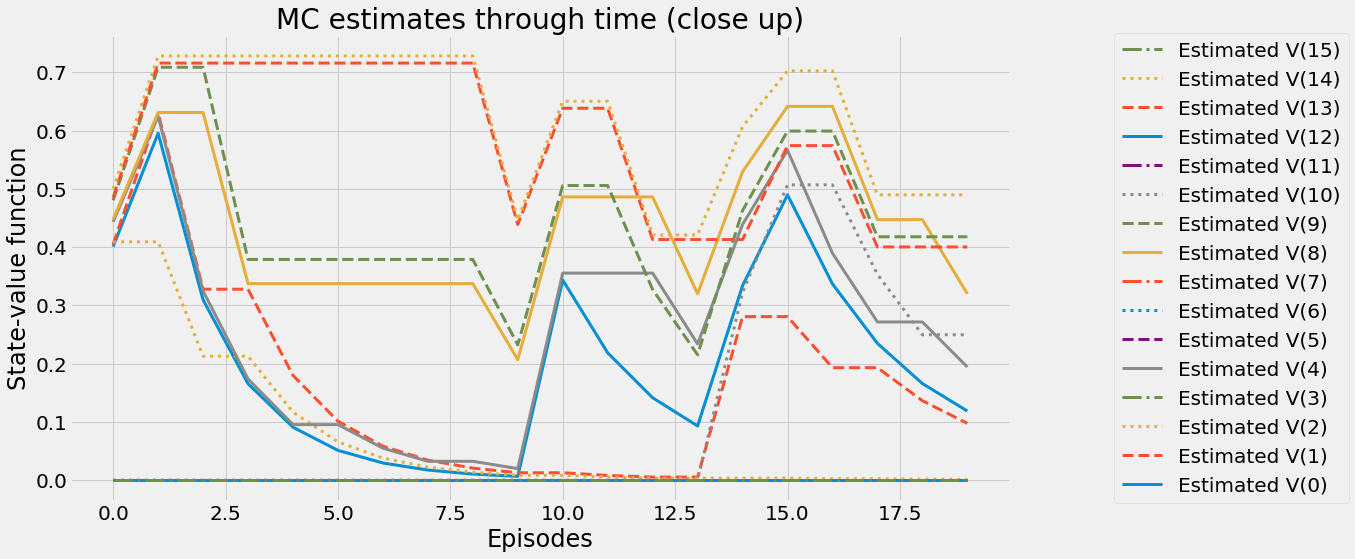

In [53]:
plot_value_function('MC estimates through time (close up)', V_track_mc[:20], None, log=False)

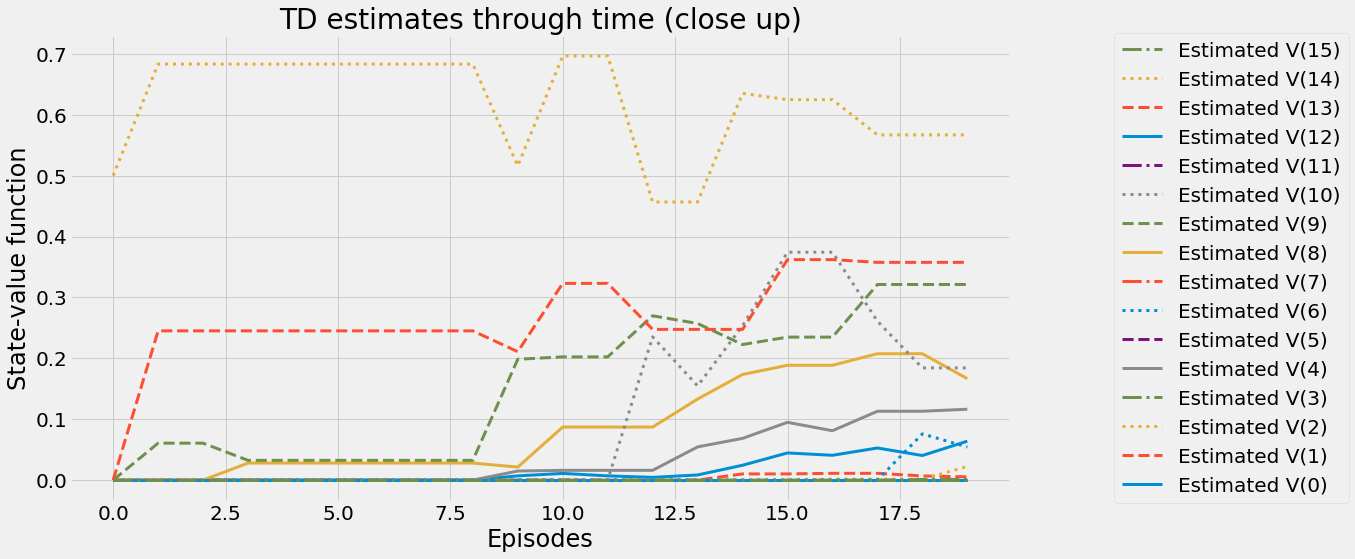

In [54]:
plot_value_function('TD estimates through time (close up)', V_track_td[:20], None, log=False)

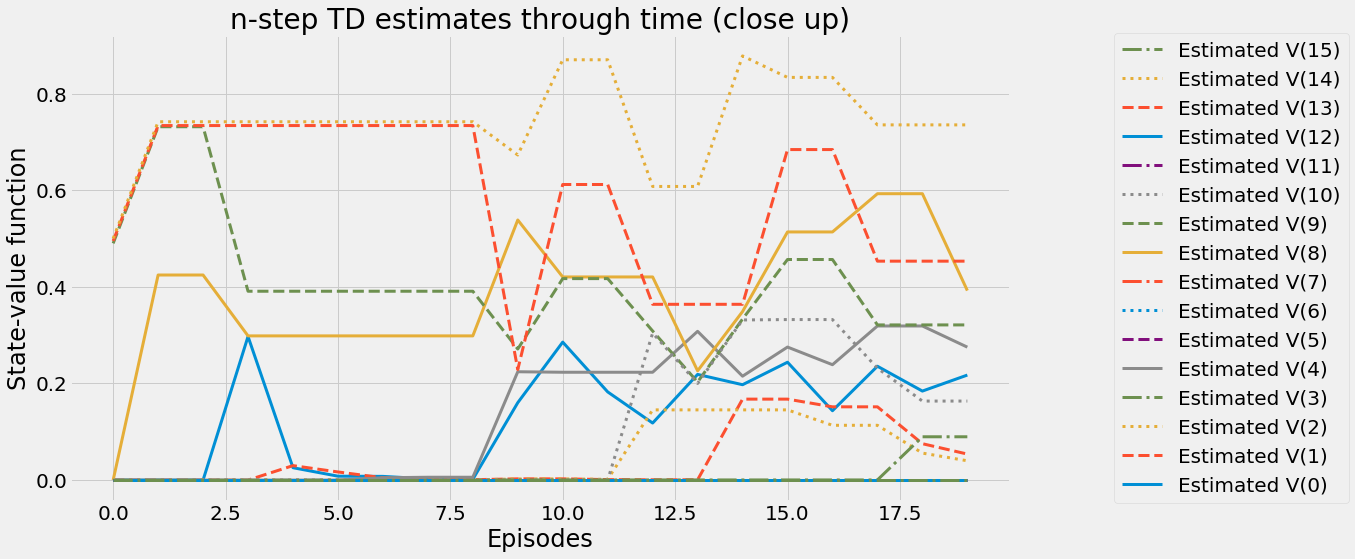

In [55]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:20], None, log=False)

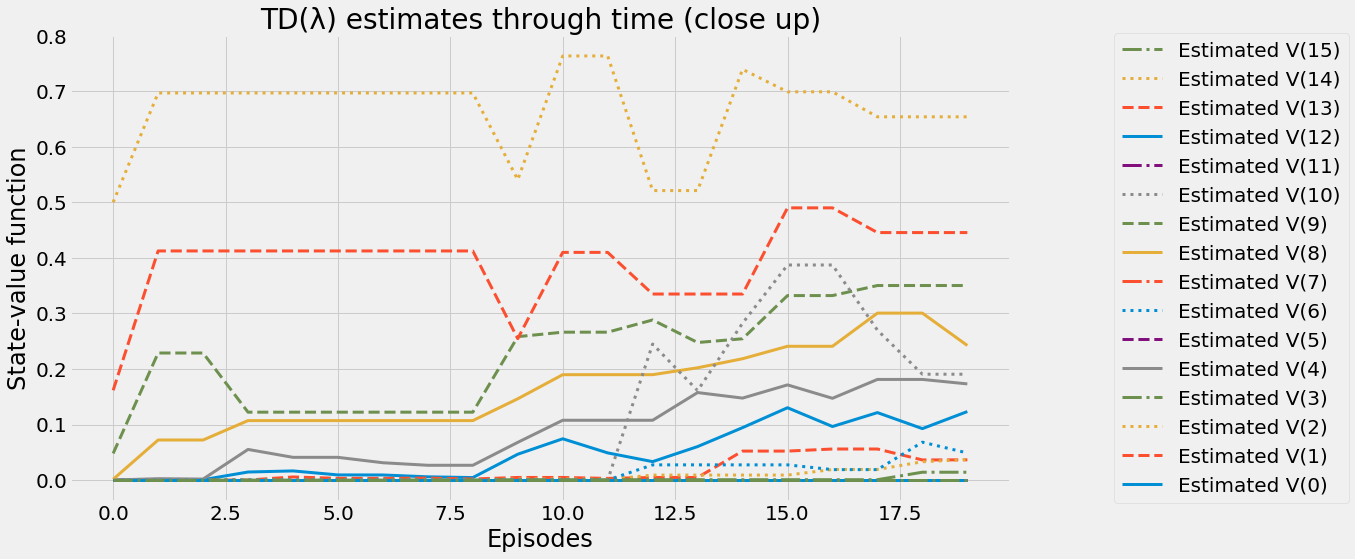

In [56]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:20], None, log=False)